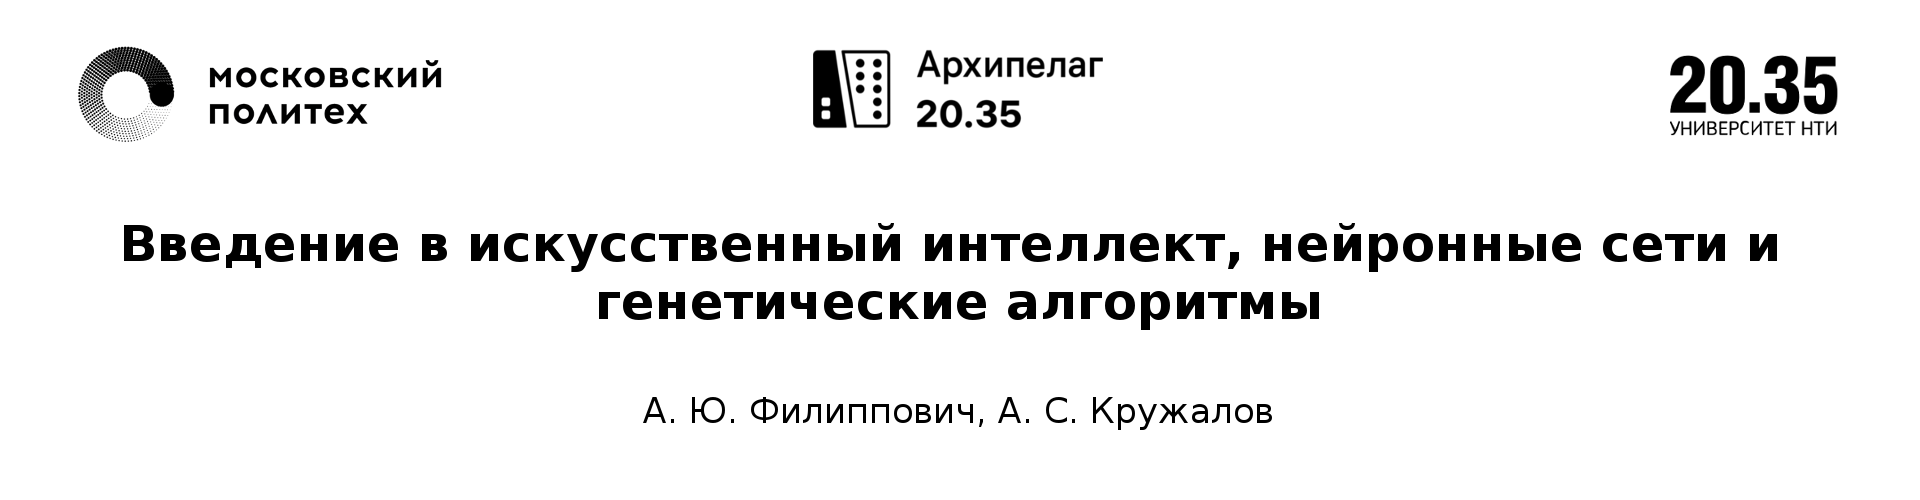

# **Решение задачи коммивояжёра с помощью генетического алгоритма**

<a href="mailto:alexkruzhalov@gmail.com">Кружалов А. С.</a> | Leader-ID: `#955144#`

**10 ноября 2020 г.**



В данной работе вам предстоит реализовать генетический алгоритм для решения задачи коммивояжёра. Вам предлагается решить конкретный экземпляр задачи коммивояжера – BERLIN52, взятый из репозитория [TSPLIB](http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsplib.html). В этой задаче необходимо найти кратчайший маршрут, соединяющий 52 точки на карте Берлина.

Ниже представлен код для загрузки файлов с исходными данными задачи. В файле `berlin52.tsp.txt` содержится список координат вершин, через которые требуется построить маршрут. В файле `berlin52.opt.tour.txt` представлена последовательность вершин, составляющих кратчайший маршрут. Его длина составляет $7544,3659$.

In [ ]:
!wget http://ai.std-900.ist.mospolytech.ru/genetic_algorithms/berlin52.tsp.txt
!wget http://ai.std-900.ist.mospolytech.ru/genetic_algorithms/berlin52.opt.tour.txt

In [ ]:
import re
import random
import math
import numpy as np
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Ниже представлена заготовка класса генетического алгоритма. Реализуйте недостающие части.

In [ ]:
class GeneticTSP:
    def __init__(self, ch_size=5, population_size=100, max_generations=1000, mutation_probability=0.5, tournament_group_size=2, \
                 selection_method='roulette', crossover_method='greedy', best_fraction=0.2, population=None, distance_matrix=None):
        # The length of chromosome
        self.ch_size = ch_size
        self.population_size = population_size
        self.max_generations = max_generations
        self.mutation_probability = mutation_probability
        self.tournament_group_size = tournament_group_size
        assert selection_method in ['roulette', 'tournament']
        self.selection_method = selection_method
        assert crossover_method in ['greedy', 'permutation']
        self.crossover_method = crossover_method
        # The fraction of best individuals of current generation 
        # that will pass to the next generation unaltered (elitism). 
        self.best_fraction = best_fraction
        self.distance_matrix = distance_matrix if distance_matrix is not None else self._generate_distance_matrix()
        self.population = population or self._generate_population()
        self.best_solution = None # (Individual, fittness_func)
        
    # Generates initial population
    def _generate_population(self):
        return [Individual(size=self.ch_size, dm=self.distance_matrix) for _ in range(self.population_size)]
    
    # Generates random distance matrix 
    def _generate_distance_matrix(self):
        dm = np.random.uniform(high=100, size=(self.size, self.size))
        dm = np.tril(dm) + np.tril(dm, -1).T
        return dm
    
    # Calculates fittnes function
    # Note: fitness function must be larger for better solutions, that is why 
    # you should use the inverse value of the distance between cities as a fitness 
    # function.
    def fittnes_func(self, individual, eps=-7544.3659):
        dist = 0
        for i in range(self.ch_size):
            dist += self.distance_matrix[individual.chromosome[i], individual.chromosome[(i+1) % self.ch_size]]
        return 1/(dist + eps + 0.01)

    # Implements roulette selection
    # Return value: list of individuals.
    # Hint: you can use np.random.choice function to select individuals according 
    # their selection probabilities.
    def _selection_roulette(self):
        # your code here

    # Implements tournament selection
    # Return value: list of individuals.
    def _selection_tournament(self):
        # your code here
        

    # Implements selection
    def selection(self):
        if self.selection_method == 'roulette':
            return self._selection_roulette()
        elif self.selection_method == 'tournament': 
            return self._selection_tournament()
    
    # Runs the genetic algorithm
    def perform(self):
        history = {'best': [], 'mean': [], 'worst': []}

        for k in range(self.max_generations):
            new_population = []

            # Select individuals for crossover
            selected = self.selection()

            # Random pairing for crossover
            while len(selected) > 0:
                parent1 = None
                parent2 = None
                tries = 0
                while parent1 is None or parent2 is None:
                    parent_index = np.random.randint(len(selected))
                    if parent1 is None:
                        parent1 = selected.pop(parent_index)
                    elif parent2 is None and (parent1 != selected[parent_index] or tries >= 10):
                        parent2 = selected.pop(parent_index)
                    else:
                        tries += 1

                offsprings = parent1.crossover(parent2, method=self.crossover_method)
                for offspring in offsprings:
                    offspring.mutation(self.mutation_probability)

                new_population += list(offsprings)

            # Form new population from best individuals (elitism) and offsprings
            # Hint: to sort individuals according their fitness function values 
            # you can use function `sorted` with parameter `key=self.fittnes_func`. 
            # New population must be saved in self.population attribute.

            # your code here

            f = np.array(list(map(self.fittnes_func, self.population)))
            max_index = np.where(f == f.max())[0][0]
            history['best'].append(f[max_index])
            history['mean'].append(f.mean())
            history['worst'].append(f.min())

            print('Generation {}: best {}, mean {}, worst {}'.format(k + 1, history['best'][-1], history['mean'][-1], history['worst'][-1]))

            if self.best_solution is None or self.best_solution[1] < f[max_index]:
                self.best_solution = (self.population[max_index], f[max_index])

        return self.best_solution[0], history        

Ниже представлена заготовка класса особи. В этом классе должны быть реализованы операторы скрещивания и мутации. Реализуйте недостающие части.

*Замечание: так как мы ищем цикл в графе, для нас важны только положения вершин графа друг относительно друга в рамках маршрута, а не конкретные их позиции в массиве, однако, для проверки двух маршрутов на равенство (например, чтобы проверить, есть ли уже такая особь в популяции), нам может понадобиться "выровнять" их для удобства сравнения. Этого можно добиться путём циклического сдвига ( функция `np.roll`). Такое сравнение реализовано в методе `__eq__`.*

In [ ]:
class Individual:
    def __init__(self, size=None, chromosome=None, dm=None):
        assert size is not None or chromosome is not None
        self.size = size if size else len(chromosome)
        self.chromosome = chromosome if chromosome is not None else self._generate_chromosome()
        self.dm = dm
        
    def __eq__(self, other):
        if not isinstance(other, self.__class__):
            return False
        r = self.chromosome[::-1]
        first_city_index = np.where(self.chromosome == other.chromosome[0])[0][0]
        if np.all(np.roll(self.chromosome, self.size - first_city_index) == other.chromosome) or \
           np.all(np.roll(r, self.size - (self.size - first_city_index - 1)) == other.chromosome):
            return True
        return False

    def __repr__(self):
        return "_".join(map(str, self.chromosome))
        
    # Generates random chromosome
    def _generate_chromosome(self):
        return np.random.permutation(self.size)
    
    # Implement mutation with given probability
    # Hint: you can implement it as swapping two random genes. 
    def mutation(self, prob):
        # your code here

    # Generates one offspring using permutation crossover operator
    # Return value: instance of class Individual
    # Hint: description of permutation operator you can find here -- 
    # http://www.rubicite.com/Tutorials/GeneticAlgorithms/CrossoverOperators/Order1CrossoverOperator.aspx
    def _generate_permutation_offspring(self, p1, p2):
        # your code here

    # Generates one offspring using greedy crossover operator
    # Return value: instance of class Individual
    def _generate_greedy_offspring(self, other):
        # your code here

    def _permutation_crossover(self, other):
        offspring1 = self._generate_permutation_offspring(self, other)
        offspring2 = self._generate_permutation_offspring(other, self)
        return offspring1, offspring2

    def _greedy_crossover(self, other):
        offspring1 = self._generate_greedy_offspring(other)
        offspring2 = self._generate_greedy_offspring(other)
        return offspring1, offspring2

    # Implements crossover
    def crossover(self, other, method='greedy'):
        if method == 'greedy':
            return self._greedy_crossover(other)
        else:
            return self._permutation_crossover(other)

Функция `parse_tsp_file` парсит файл с координатами вершин графа и возвращает их как `numpy.array`. Функция `read_optimal` считывает оптимальный маршрут и также возвращает его в виде `numpy.array`.

In [ ]:
def parse_tsp_file(filename='berlin52.tsp.txt'):
    result = []
    with open(filename) as f:
        for line in f:
            m = re.match(r'(\d+) (\d+\.\d+) (\d+\.\d+)', line)
            if m:
                result.append(m.groups()[1:])
    return np.array(result, dtype=np.float32)  

In [ ]:
def read_optimal(filename='berlin52.opt.tour.txt'):
    result = []
    with open(filename) as f:
        for line in f:
            m = re.match(r'^\d+$', line.rstrip())
            if m:
                result.append(m.group())
    return np.array(result, dtype=np.int32) - 1 

In [ ]:
def plot_tour(tour, nodes):
    plt.figure(dpi=150)
    plt.scatter(nodes[:, 0], nodes[:, 1])
    for i in range(len(tour)):
        x1, y1 = nodes[tour[i]]
        x2, y2 = nodes[tour[(i+1) % len(tour)]]
        if x1 > x2:
            x1, x2 = x2, x1
            y1, y2 = y2, y1
        x = np.linspace(x1, x2)
        y = (x - x1)*(y2-y1)/(x2 - x1) + y1
        plt.plot(x, y, "r--")
    plt.show()

In [ ]:
nodes = parse_tsp_file()
dm = euclidean_distances(nodes)
optimal_tour = read_optimal()

Установите значения параметров и запустите генетический алгоритм. Попробуйте поменять значения параметров и выяснить, как это повлияет на работу генетического алгоритма.

In [ ]:
params = {
    'ch_size': 52, 
    'population_size': 100, 
    'max_generations': 1000, 
    'mutation_probability': 0.5, 
    'tournament_group_size': 2, 
    'selection_method': 'roulette', 
    'crossover_method': 'greedy', 
    'best_fraction': 0.2, 
    'population': None, 
    'distance_matrix': dm
}

In [ ]:
ga = GeneticTSP(**params)

In [ ]:
solution, history = ga.perform()

Generation 1: best 6.27530705962427e-05, mean 5.259348752282642e-05, worst 4.775415370670402e-05
Generation 2: best 6.681942174930474e-05, mean 5.677715819089693e-05, worst 5.074022703618751e-05
Generation 3: best 7.341652286609981e-05, mean 5.9723018728969267e-05, worst 5.280449897316872e-05
Generation 4: best 8.000267794729578e-05, mean 6.133318527540105e-05, worst 5.2221256340789504e-05
Generation 5: best 8.000267794729578e-05, mean 6.311820672532664e-05, worst 5.3842671864531583e-05
Generation 6: best 8.176745527551365e-05, mean 6.43850956994066e-05, worst 5.435210702408902e-05
Generation 7: best 8.438461395842746e-05, mean 6.531548755658187e-05, worst 5.537893014099386e-05
Generation 8: best 9.082243469008099e-05, mean 6.63441526072501e-05, worst 5.4488183783618495e-05
Generation 9: best 9.082243469008099e-05, mean 6.820916205514472e-05, worst 5.6675572513634836e-05
Generation 10: best 9.082243469008099e-05, mean 6.8609557080241e-05, worst 5.787128189337745e-05
Generation 11: best

Постройте график, показывающий, как менялись значения функции приспособленности наилучшей особи, наихудщей особи, а также в среднем по популяции в процессе работы генетического алгоритма.

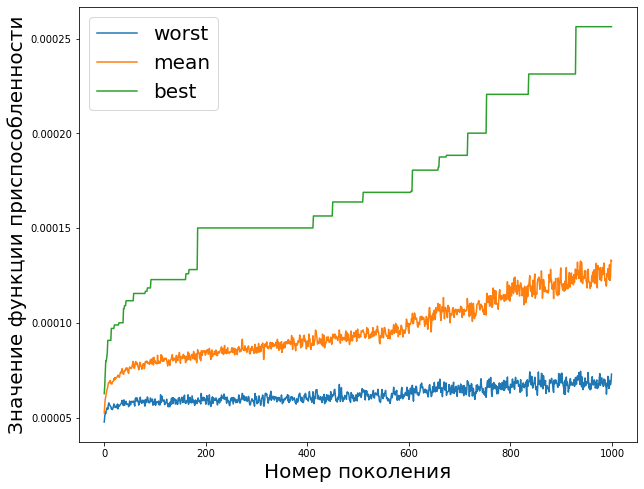

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history['worst'])
plt.plot(history['mean'])
plt.plot(history['best'])
plt.legend(['worst', 'mean', 'best'], fontsize=20)
plt.xlabel('Номер поколения', fontsize=20)
plt.ylabel('Значение функции приспособленности', fontsize=20)
plt.show()

Постройте графики, показывающие оптимальный маршрут и маршрут, найденный генетическим алгоритмом. Сравните полученные результаты.

Длина маршрута: 7543.0


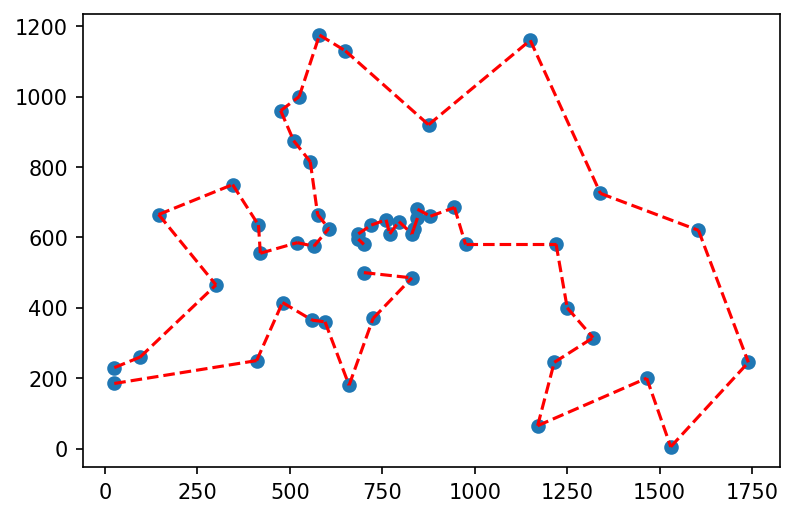

In [ ]:
print("Длина маршрута: {}".format(round(1/ga.fittnes_func(Individual(chromosome=optimal_tour)) - 1 + 7544.3659)))
plot_tour(optimal_tour, nodes)

Длина маршрута: 11446.0


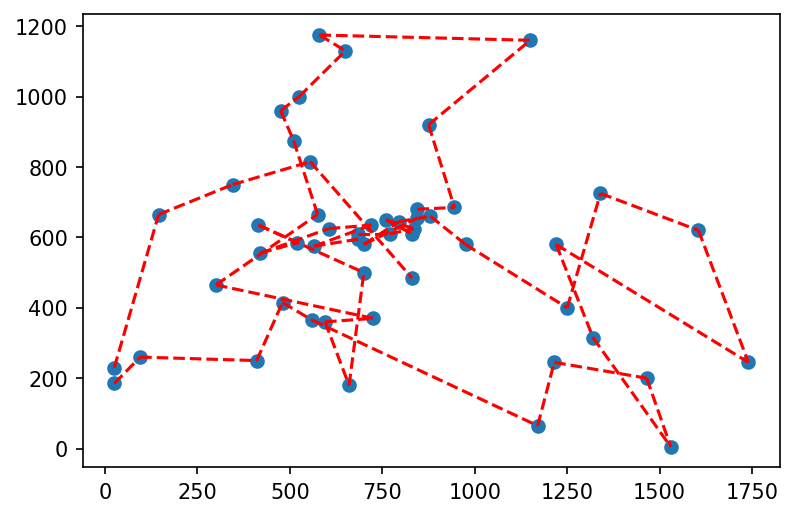

In [ ]:
print("Длина маршрута: {}".format(round(1/ga.fittnes_func(solution) - 1 + 7544.3659)))
plot_tour(solution.chromosome, nodes)